In [3]:
import yfinance as yf
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model


In [4]:
##Download data
ticker = 'AAPL'
data = yf.download(ticker,start='2015-01-01',end='2025-01-01')
print(data.columns)
prices = data['Close'].dropna()

#compile daily return
returns = 100* prices.pct_change().dropna()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


<Axes: xlabel='Date'>

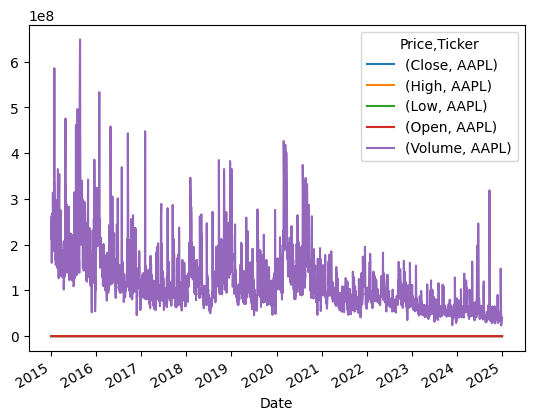

In [5]:
data.head(5)
data.plot()

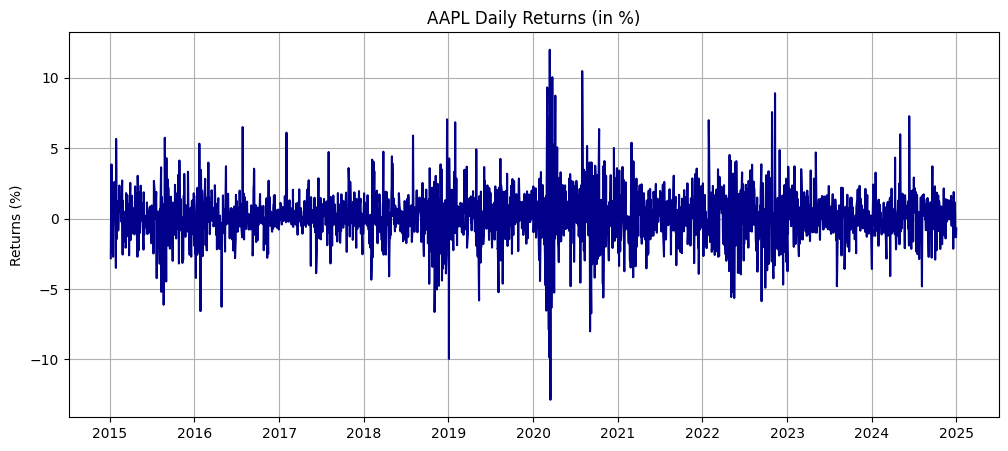

In [6]:
plt.figure(figsize=(12,5))
plt.plot(returns,color='darkblue')
plt.title(f'{ticker} Daily Returns (in %)')
plt.ylabel('Returns (%)')
plt.grid(True)
plt.show()


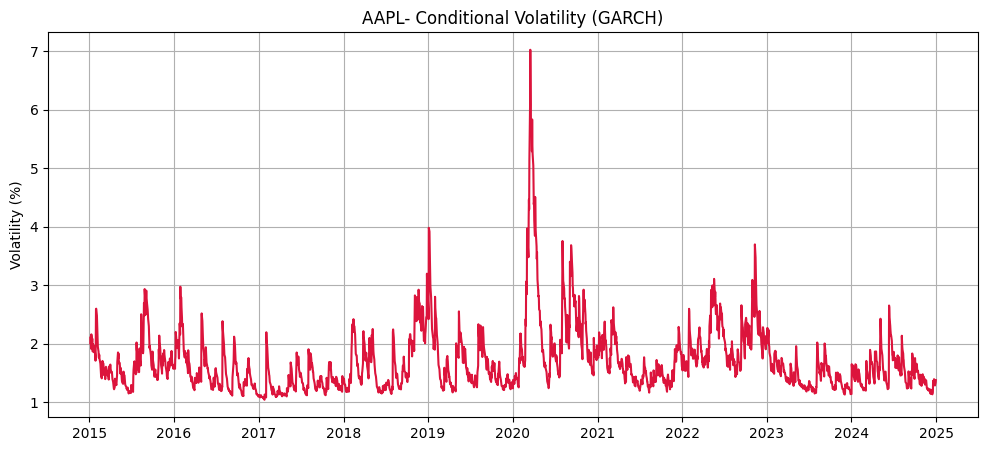

In [7]:
#Fit Garch
model = arch_model(returns,vol='Garch',p=1,q=1)
garch_fit = model.fit(disp='off')
plt.figure(figsize=(12,5))
plt.plot(garch_fit.conditional_volatility, color= 'crimson')
plt.title(f'{ticker}- Conditional Volatility (GARCH)')
plt.ylabel('Volatility (%)')
plt.grid(True)
plt.show()

In [8]:
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4793.50
Distribution:                  Normal   AIC:                           9595.01
Method:            Maximum Likelihood   BIC:                           9618.33
                                        No. Observations:                 2515
Date:                Sun, Jun 15 2025   Df Residuals:                     2514
Time:                        04:16:10   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1694  3.257e-02      5.200  1.991e-07 [  0.106,  0.23

In [22]:
market = yf.download('^GSPC',start='2015-01-01',end='2025-01-01')
market_returns = 100* market['Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [23]:
# Align returns with AAPL
combined = pd.concat([returns, market_returns], axis=1)
combined.columns = ['AAPL', 'Market']
combined.dropna(inplace=True)

In [24]:
print(combined.columns)

Index(['AAPL', 'Market'], dtype='object')


In [25]:
import statsmodels.api as sm

X = sm.add_constant(combined['Market'])
model = sm.OLS(combined['AAPL'],X).fit()
beta = model.params['Market']
alpha = model.params['const']
print(f"Beta: {round(beta,3)}, Alpha: {round(alpha,3)}")

Beta: 1.193, Alpha: 0.051


In [26]:
#Sharpe Ration
risk_free_rate = 0.05/252 *100
excess_returns = returns - risk_free_rate
sharpe_ratio = excess_returns.mean()/excess_returns.std()
print(f"Sharpe Ratio: {round(sharpe_ratio, 3)}")

Sharpe Ratio: Ticker
AAPL    0.05
dtype: float64


Max Drawdown: Ticker
AAPL   -38.52
dtype: float64%


<function matplotlib.pyplot.show(close=None, block=None)>

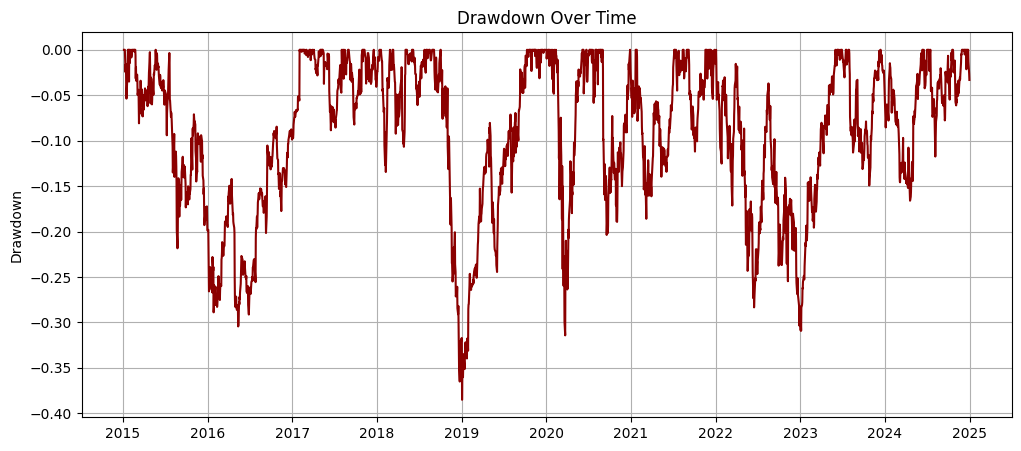

In [30]:
#Maximum Drawdown(Worst drop)
cum_returns = (1 + returns/100).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max)/ rolling_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: {round(max_drawdown *100, 2)}%")

plt.figure(figsize=(12,5))
plt.plot(drawdown,color='darkred')
plt.title('Drawdown Over Time')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show

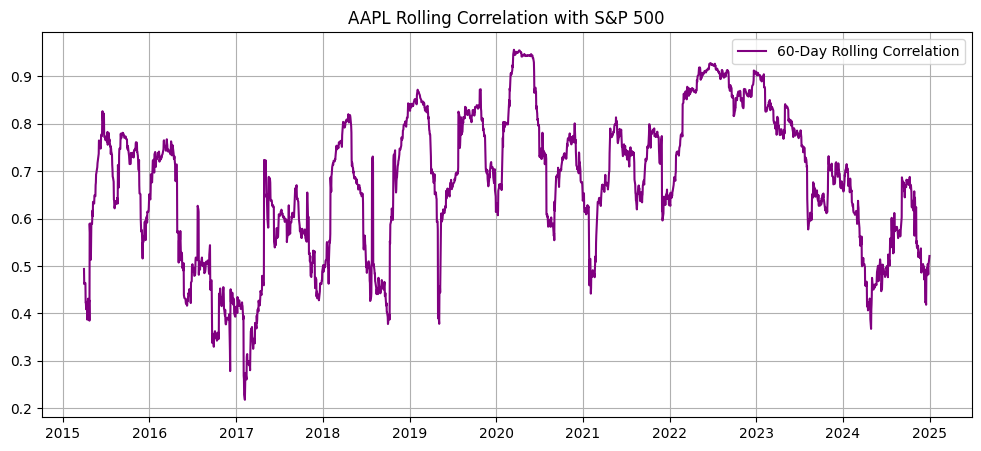

In [32]:
#Rolling Correlation with Market
rolling_corr = combined['AAPL'].rolling(60).corr(combined['Market'])

plt.figure(figsize=(12,5))
plt.plot(rolling_corr,label ='60-Day Rolling Correlation', color='purple')
plt.title(f"AAPL Rolling Correlation with S&P 500")
plt.grid(True)
plt.legend()
plt.show()